In [33]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy.signal import convolve2d
from imageio.v3 import imread
import matplotlib.pyplot as plt

import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

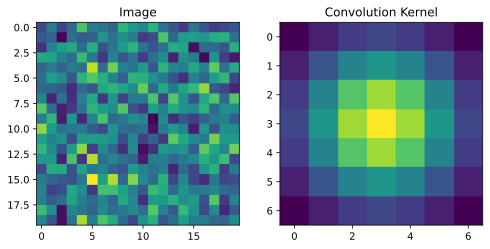

In [ ]:
#### Manual 2D convolution in numpy/Scipy
# Image
imgN = 20
image = np.random.randn(imgN, imgN)

# Convolution kernel
kernelN = 7
Y, X = np.meshgrid(np.linspace(-3, 3, kernelN), np.linspace(-3, 3, kernelN))
kernel = np.exp(-(X**2 + Y**2) / 7)  # Gaussian kernel

# Let's see what they look like
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(image)
ax[0].set_title("Image")

ax[1].imshow(kernel)
ax[1].set_title("Convolution Kernel")

plt.show()

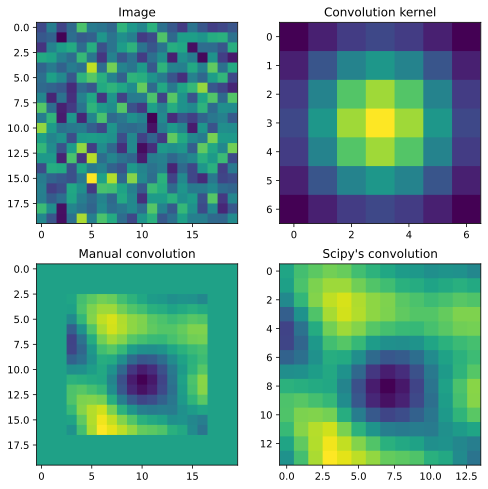

In [ ]:
# Now the manual convolution
conv_out1 = np.zeros((imgN, imgN))
half_kernel = kernelN // 2

for row in range(half_kernel, imgN - half_kernel):
    for col in range(half_kernel, imgN - half_kernel):
        # cut out a piece of the image
        pieceOfImg = image[
            row - half_kernel : row + half_kernel + 1,
            col - half_kernel : col + half_kernel + 1,
        ]
        # convolve with the kernel
        dot_product = np.sum(pieceOfImg * kernel)
        conv_out1[row, col] = dot_product

# Use scipy for convolution
conv_out2 = convolve2d(image, kernel, mode="valid")

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0, 0].imshow(image)
ax[0, 0].set_title("Image")

ax[0, 1].imshow(kernel)
ax[0, 1].set_title("Convolution kernel")

ax[1, 0].imshow(conv_out1)
ax[1, 0].set_title("Manual convolution")

ax[1, 1].imshow(conv_out2)
ax[1, 1].set_title("Scipy's convolution")

plt.show()

(1675, 3000, 3)


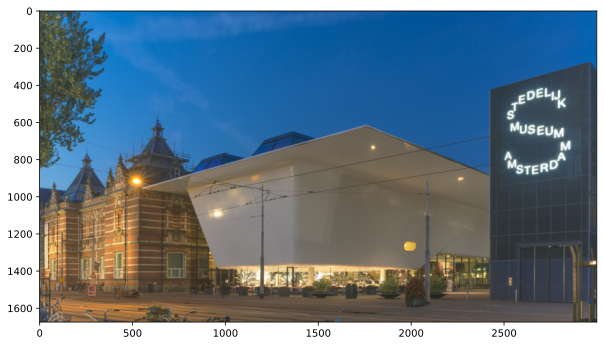

(1675, 3000)


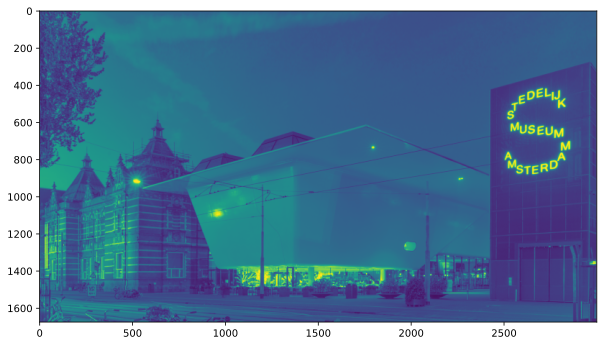

In [36]:
#### Example of convolution with different kernal in a real image
# Read a pic form web
bathtub = imread(
    uri="https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg"
)
print(bathtub.shape)

# let's see what the famous bathtub looks like
fig = plt.figure(figsize=(10, 6))
plt.imshow(bathtub)
plt.show()
# Transform image to 2D for convenience (Not necessary for convolution)
bathtub = np.mean(bathtub, axis=2)
bathtub = bathtub / np.max(bathtub)
print(bathtub.shape)
fig = plt.figure(figsize=(10, 6))
plt.imshow(bathtub)

In [39]:
## Let's create a kernel that detects edges
# Vertical edge detection kernel
VK = np.array(
    [
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1],
    ]
)

# Horizontal edge detection kernel
HK = np.array(
    [
        [-1, -1, -1],
        [0, 0, 0],
        [1, 1, 1],
    ]
)

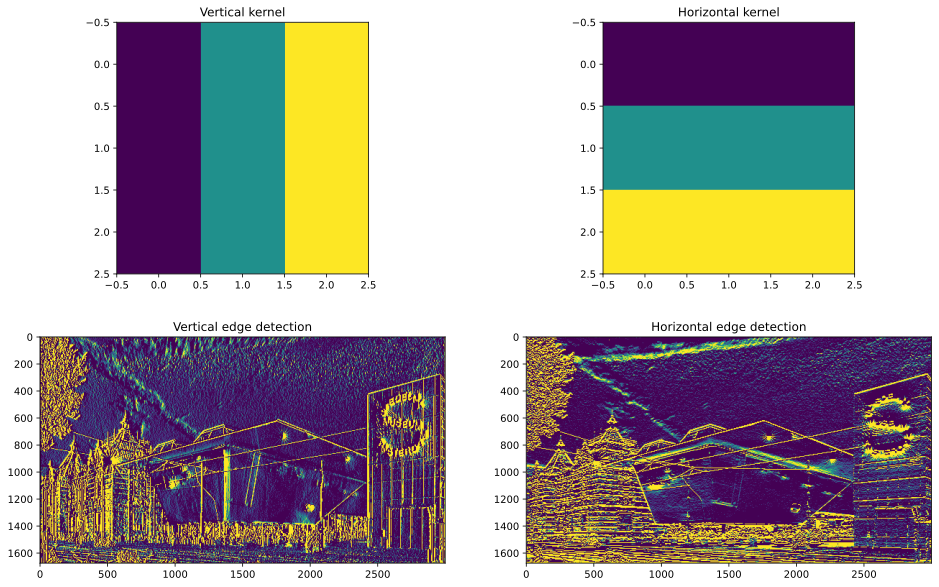

In [40]:
# Let's see what convelution with these kernels looks like
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0, 0].imshow(VK)
ax[0, 0].set_title("Vertical kernel")
ax[0, 1].imshow(HK)
ax[0, 1].set_title("Horizontal kernel")

# Run convolution and show the results
conv_vert = convolve2d(bathtub, VK, mode="same")
conv_horiz = convolve2d(bathtub, HK, mode="same")
ax[1, 0].imshow(conv_vert, vmin=0, vmax=.01)
ax[1, 0].set_title("Vertical edge detection")
ax[1, 1].imshow(conv_horiz, vmin=0, vmax=.01)
ax[1, 1].set_title("Horizontal edge detection")
plt.show()

In [44]:
# Now in pytorch
VK_torch = torch.tensor(VK).view(1,1,3,3).double()
HK_torch = torch.tensor(HK).view(1,1,3,3).double()
bathtub_torch = torch.tensor(bathtub).view(1, 1, bathtub.shape[0], bathtub.shape[1]).double()
print(bathtub_torch.shape)
print(VK_torch.shape)
print(HK_torch.shape)

torch.Size([1, 1, 1675, 3000])
torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 3, 3])


In [45]:
C = F.conv2d(bathtub_torch, VK_torch)
print(C.shape)

torch.Size([1, 1, 1673, 2998])


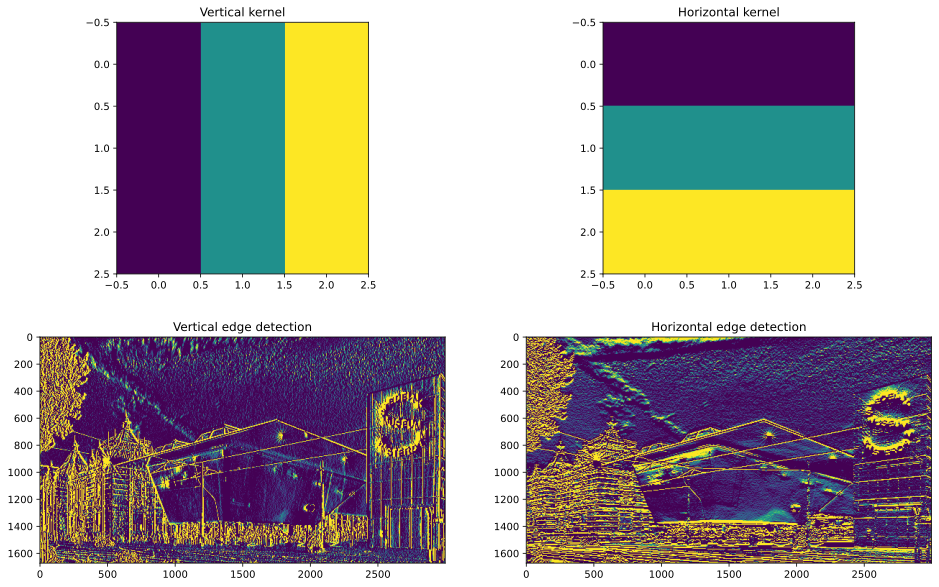

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0, 0].imshow(VK_torch.squeeze().detach().cpu())
ax[0, 0].set_title("Vertical kernel")
ax[0, 1].imshow(HK_torch.squeeze().detach().cpu())
ax[0, 1].set_title("Horizontal kernel")

# Run convolution and show the results
conv_vert = F.conv2d(bathtub_torch, VK_torch)
img_vert = torch.squeeze(conv_vert.detach().cpu())
ax[1, 0].imshow(img_vert, vmin=0, vmax=.01)
ax[1, 0].set_title("Vertical edge detection")

conv_hor = F.conv2d(bathtub_torch, HK_torch)
img_hor = torch.squeeze(conv_hor.detach().cpu())
ax[1, 1].imshow(img_hor, vmin=0, vmax=.01)
ax[1, 1].set_title("Horizontal edge detection")

plt.show()